# Daily Average Glucose

This notebook generates daily average glucose chart from blood glucose readings held in the Health Tracker database and retrieved via the Health Tracker Web Service:

- A line plot for daily mean
- +/- 1 standard deviation shaded area, indicating daily variability
- Target zone indicator

This is done for one or more date range and the data is plotted for each on the same axes for comparison purposes.

The charts include the median line.

Before attempting to run the notebook:

- Make sure the variables defined in "config.ipynb" are set correctly
- Set the reporting date ranges and export options in the first code cell

In [12]:
from datetime import datetime

# Set up the chart definitions for each range consisting of:
# Start date
# Number of days
# Chart line colour
# Chart fill colour
# Chart marker
chart_definitions = [
    (datetime(2025, 4, 17, 0, 0, 0), 11, "red", "orange", "x"),
    (datetime(2025, 5, 9, 0, 0, 0), 11, "blue", "blue", "o"),
    (datetime(2025, 6, 27, 0, 0, 0), 11, "green", "green", "+")
]

# Whether to export the data to a spreadsheet
export_spreadsheet = True

# Export format for the chart:
# PNG     - export as PNG image
# PDF     - export as PDF file
# <blank> - do not export
chart_export_format = "PNG"

In [13]:
# Set the percentile limits
lower_percentile = 0
upper_percentile = 100

# Set the Y-axis limits
y_min = 3
y_max = 15

In [14]:
%run ../api.ipynb
%run ../config.ipynb
%run ../export.ipynb

In [15]:
from datetime import timedelta
import numpy as np

# Log in to the service and get the person ID
token = authenticate(url, username, password)
person_id = get_person_id(url, token, firstnames, surname)

# Iterate over each definition
daily_stats_ranges = []
for definition in chart_definitions:
    # Calculate the end date
    start_date, days, _, _, _ = definition
    end_date = start_date + timedelta(days=days)

    # Load the data
    df = get_blood_glucose_measurements(url, token, person_id, start_date, end_date)
    if not df.empty:
        # Rename the date column to timestamp and generate a date-only column
        df.rename(columns={ "date": "timestamp" }, inplace=True)
        df["date"] = df["timestamp"].dt.date

        # Group by date and calculate mean and standard deviation
        daily_stats = df.groupby("date")["level"].agg(["mean", "std"]).reset_index()

        # Add a number of days since the start for plotting the data
        minimum_date = daily_stats["date"].min()
        daily_stats["days"] = (daily_stats["date"] - minimum_date)/ np.timedelta64(1, "D")

        # Add the daily stats to the collection
        daily_stats_ranges.append(daily_stats)
    else:
        daily_stats_ranges.append(None)

In [16]:
# Export the data to a spreadsheet
if export_spreadsheet:
    # Construct the export dictionary
    export_dictionary = {}
    for i, daily_stats in enumerate(daily_stats_ranges):
        key = f"Daily Mean Range {i + 1}"
        export_dictionary[key] = daily_stats

    # Export the data
    export_to_spreadsheet("glucose_daily_mean_comparison", export_dictionary)

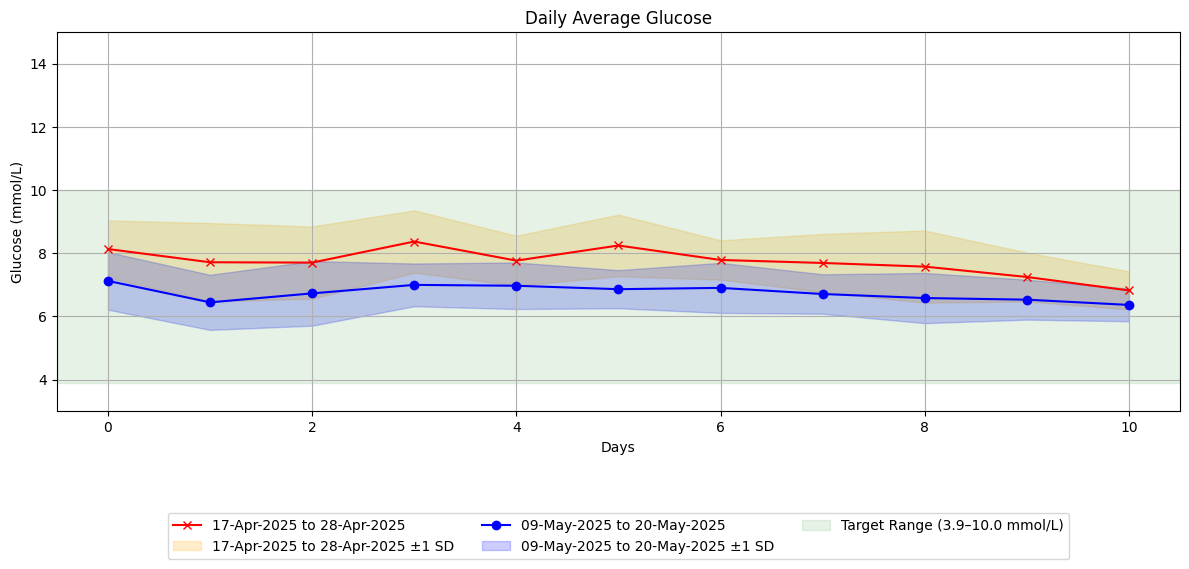

In [17]:
import matplotlib.pyplot as plt

# Plot setup
plt.figure(figsize=(12, 6))

# Iterate over each definition
for i, definition in enumerate(chart_definitions):
    # Extract the chart properties and data
    start_date, days, line_colour, fill_colour, marker = definition
    end_date = start_date + timedelta(days=days)
    label = f"{start_date.strftime('%d-%b-%Y')} to {end_date.strftime('%d-%b-%Y')}"

    # Check the current range has some data before attempting to plot it
    daily_stats = daily_stats_ranges[i]
    if daily_stats is not None:
        # Plot daily mean glucose
        plt.plot(
            daily_stats["days"],
            daily_stats["mean"],
            label=label,
            color=line_colour,
            marker=marker)

        # Plot ±1 standard deviation as a shaded area
        plt.fill_between(
            daily_stats["days"],
            daily_stats["mean"] - daily_stats["std"],
            daily_stats["mean"] + daily_stats["std"],
            color=fill_colour,
            alpha=0.2,
            label=f"{label} ±1 SD"
        )

# Add target range band: 3.9–10.0 mmol/L
plt.axhspan(3.9, 10.0, color="green", alpha=0.1, label="Target Range (3.9–10.0 mmol/L)")

# Formatting
plt.title("Daily Average Glucose")
plt.xlabel("Days")
plt.ylabel("Glucose (mmol/L)")
plt.ylim(y_min, y_max)
plt.grid(True)

# Legend_range_one below chart
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.tight_layout()

# Export to PNG or PDF, if required
export_chart("glucose_daily_mean_comparison", None, chart_export_format)

# Show the plot
plt.show()
